In [1]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_eda import eda_job
from params import *
from configuration import base_folder
import os

In [2]:
concat = []
for run_key in run_keys:
    concat.append(eda_job.get(run_key).to_dataframe())
eda = pd.concat(concat)

In [3]:
metrics = ['Tonic', 'N_SCR', 'SCR_Height','SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime']
indexes = ['participant','session']

In [4]:
def ratio_baseline(df, indexes, metrics):
    odor = df[df['session'] == 'odor'].set_index(indexes)
    music = df[df['session'] == 'music'].set_index(indexes)
    baseline = df[df['session'] == 'baseline'].set_index(indexes)
    
    data_odor = odor.values / baseline.values
    data_music = music.values / baseline.values
    
    df_odor = pd.DataFrame(data = data_odor, columns = metrics, index = odor.index)
    df_music = pd.DataFrame(data = data_music, columns = metrics, index = music.index)
    
    return pd.concat([df_odor, df_music]).reset_index()

In [5]:
eda_baselined = ratio_baseline(eda, indexes, metrics)

In [6]:
eda

,session,participant,Tonic,N_SCR,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_RecoveryTime
dim_0,,,,,,,,
0,baseline,P01,0.000003,16,1.415969e-07,2.174766e-07,2.103937,11.824375
0,music,P01,0.000003,13,1.014492e-07,1.386671e-07,2.440000,13.758923
0,odor,P01,0.000004,14,8.361952e-08,1.581679e-07,3.279929,19.477231
0,baseline,P02,0.000005,172,5.905873e-10,6.344658e-10,0.331012,0.526361
0,music,P02,0.000007,37,6.614768e-09,8.840852e-09,1.089730,2.181667
...,...,...,...,...,...,...,...,...
0,music,P30,0.000004,9,3.528788e-08,6.863551e-08,1.780222,17.223778
0,odor,P30,0.000003,9,6.233694e-09,7.693811e-09,1.018444,7.398444
0,baseline,P31,0.000003,35,4.909118e-08,6.670710e-08,1.953343,5.289324


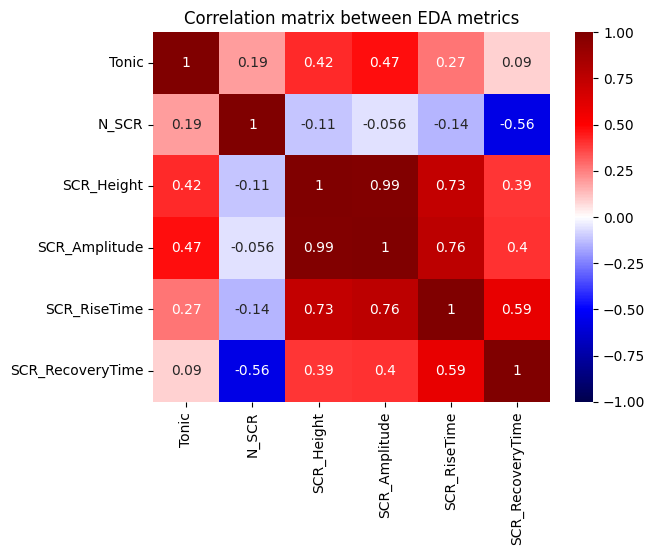

In [8]:
fig, ax = plt.subplots()
sns.heatmap(eda.corr('spearman', numeric_only = True), annot = True, cmap = 'seismic', vmin = -1, vmax = 1, ax=ax)
ax.set_title('Correlation matrix between EDA metrics')
file = base_folder / 'Figures' / 'EDA' / f'corr_matrix_eda.png'
fig.savefig(file, bbox_inches = 'tight')
fig.show()

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/l

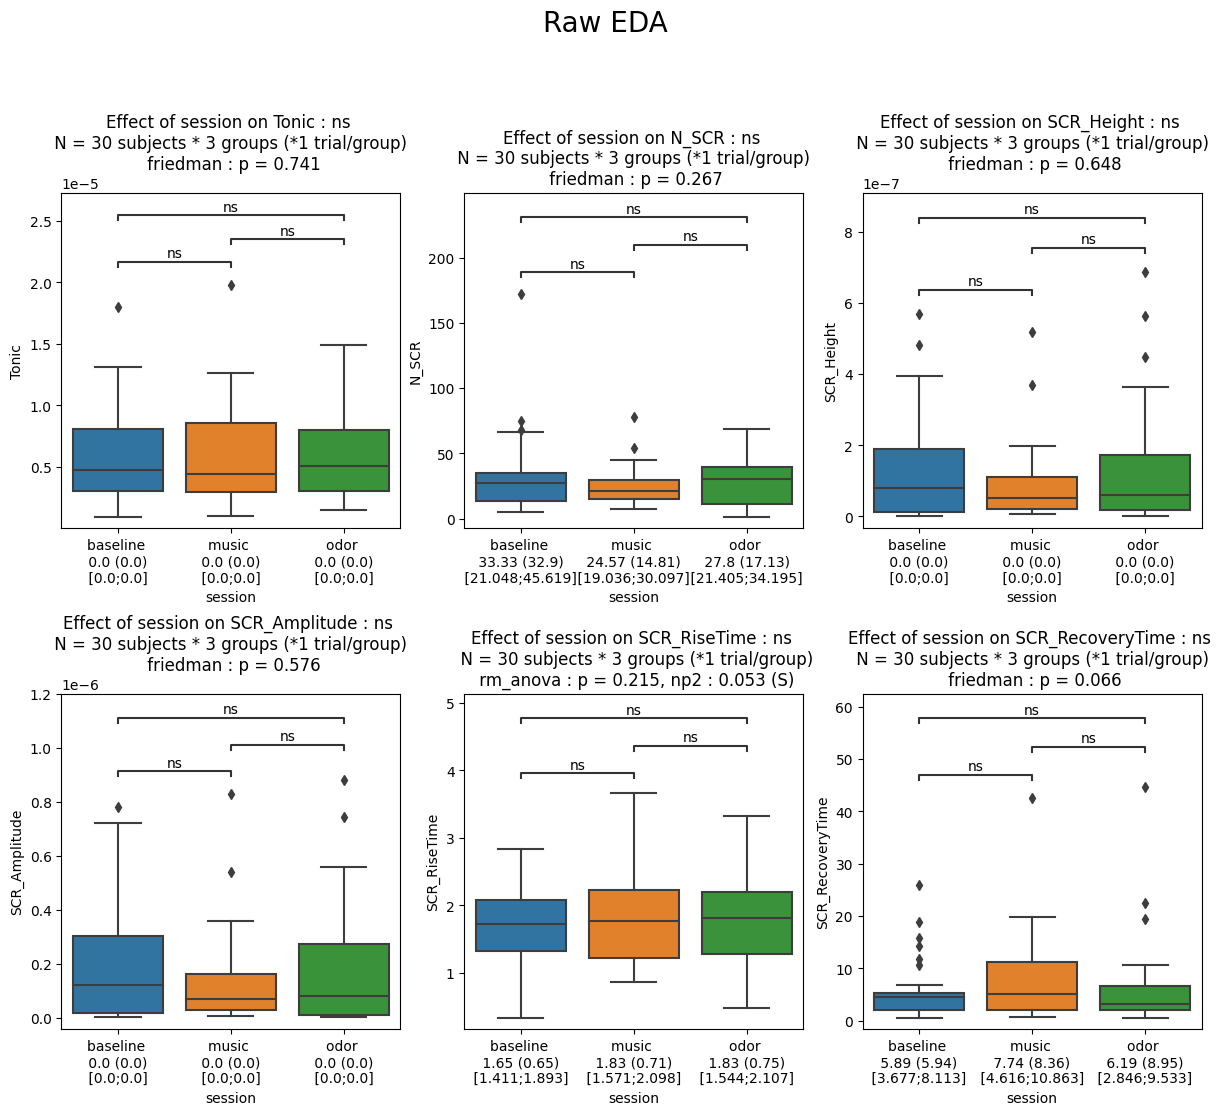

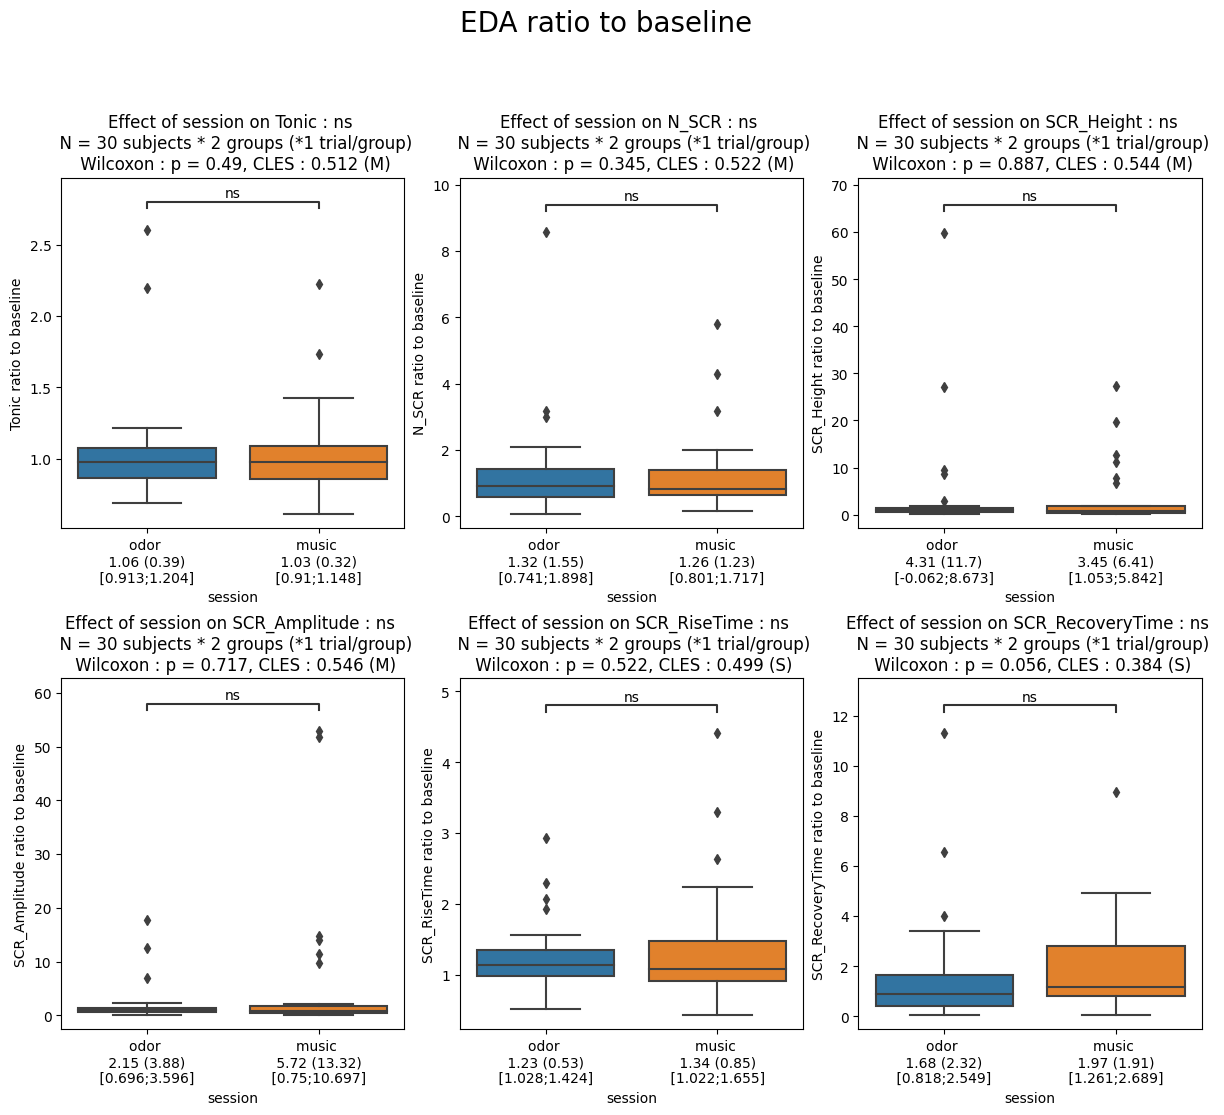

In [9]:
interesting_metrics = metrics

nrows = 2
ncols = 3
plot_metrics = np.array(interesting_metrics).reshape(nrows, ncols)

for suptitle, df in zip(['Raw EDA','EDA ratio to baseline'],[eda, eda_baselined]):
    
    fig, axs = plt.subplots(nrows, ncols, figsize = (12,10), constrained_layout = True)
    fig.suptitle(suptitle, fontsize = 20, y = 1.1)
    
    for c in range(ncols):
        for r in range(nrows):
            ax = axs[r,c]
            metric = plot_metrics[r,c]
            
            gh.auto_stats(df=df, predictor = 'session', outcome = metric, design = 'within', subject = 'participant', ax=ax)
            if 'ratio' in suptitle:
                ax.set_ylabel(ax.get_ylabel() + ' ratio to baseline')
    file = base_folder / 'Figures' / 'EDA' / f'{suptitle}.png'

    fig.savefig(file, bbox_inches = 'tight')
    fig.show()